In [2]:
# Requires Pip Install
# pip install xgboost

In [3]:
# Import the data
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

og_df = pd.read_csv('./original dataset/fake_job_postings.csv')
df = og_df.copy()
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
# implement one hot encoding for department
ohe = OneHotEncoder(min_frequency=20, handle_unknown="ignore")

# One-hot encode the 'department' column
ohe = OneHotEncoder(min_frequency=20, handle_unknown="ignore")
dept_encoded = ohe.fit_transform(df[['department']])

# Convert the sparse matrix to a dense array
dept_encoded_dense = dept_encoded.toarray()

# Create a DataFrame with the encoded department data
dept_df = pd.DataFrame(dept_encoded_dense, columns=ohe.get_feature_names_out(["department"]))

# Join the original DataFrame with the encoded department DataFrame
df = df.join(dept_df)

df.drop(['department'], axis=1, inplace=True)

In [5]:
# Display the first few rows of the updated DataFrame
df.head()

,job_id,title,location,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,...,department_R&D,department_Retail,department_Sales,department_Squiz,department_Tech,department_Technical,department_Technology,department_tech,department_nan,department_infrequent_sklearn
0,1,Marketing Intern,"US, NY, New York",NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,Account Executive - Washington DC,"US, DC, Washington",NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
df.drop(['job_id','company_profile','description','requirements','benefits','location','salary_range','title'], axis=1, inplace=True)

categorical=['employment_type', 'required_experience', 'required_education', 'industry', 'function']
df_categorical = df.copy()

df.drop(categorical, axis=1, inplace=True)

df_categorical[categorical] = df_categorical[categorical].astype('category')

In [7]:
# most basic model

x = df.drop(['fraudulent'], axis=1)
y = df['fraudulent']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# build with oversampling

x_os = df.drop(['fraudulent'], axis=1)
y_os = df['fraudulent']

x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x_os, y_os, test_size=0.2, random_state=0)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
x_train_os, y_train_os = smote.fit_resample(x_train_os, y_train_os)

# build is oversampling and categorical fields

x_os_cat = df_categorical.drop(['fraudulent'], axis=1)
y_os_cat = df_categorical['fraudulent']

x_train_os_cat, x_test_os_cat, y_train_os_cat, y_test_os_cat = train_test_split(x_os_cat, y_os_cat, test_size=0.2, random_state=0)

In [8]:
# Use test and train datafra to create a DMatrix

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

dtrain_os = xgb.DMatrix(x_train_os, label=y_train_os)
dtest_os = xgb.DMatrix(x_test_os, label=y_test_os)

dtrain_os_cat = xgb.DMatrix(x_train_os_cat, label=y_train_os_cat, enable_categorical=True)
dtest_os_cat = xgb.DMatrix(x_test_os_cat, label=y_test_os_cat, enable_categorical=True)


In [9]:
# set params and train the DMatrix
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
num_round = 10

xg_model = xgb.train(params, dtrain, num_round)
xg_model_os = xgb.train(params, dtrain_os, num_round)
xg_model_os_cat = xgb.train(params, dtrain_os_cat, num_round)

In [10]:
# predict the xg model
preds = xg_model.predict(dtest)
preds_os = xg_model_os.predict(dtest_os)
preds_os_cat = xg_model_os_cat.predict(dtest_os_cat)

# transform the predictions to binary
preds_binary = (preds >= 0.5).astype(int)
preds_binary_os = (preds_os >= 0.5).astype(int)
preds_binary_os_cat = (preds_os_cat >= 0.5).astype(int)

# check accuracy of the model
print('Base Model: ', balanced_accuracy_score(y_test, preds_binary))
print('Oversampled Model: ', balanced_accuracy_score(y_test_os, preds_binary_os))
print('Oversample Categorized Model: ', balanced_accuracy_score(y_test_os_cat, preds_binary_os_cat))

Base Model:  0.5356555710218648
Oversampled Model:  0.7522440469030147
Oversample Categorized Model:  0.6418919305963694


Confusion Matrix:
[[3421    2]
 [ 142   11]]


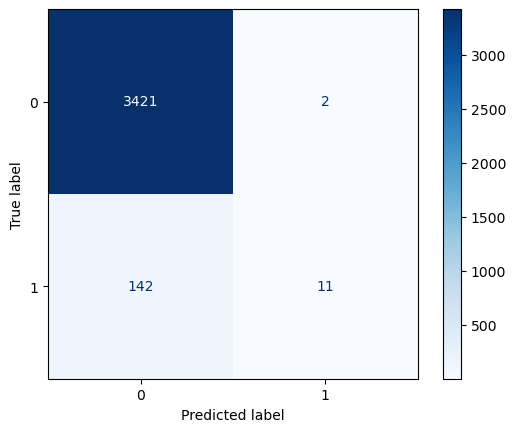

In [11]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, preds_binary)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[2756  667]
 [  46  107]]


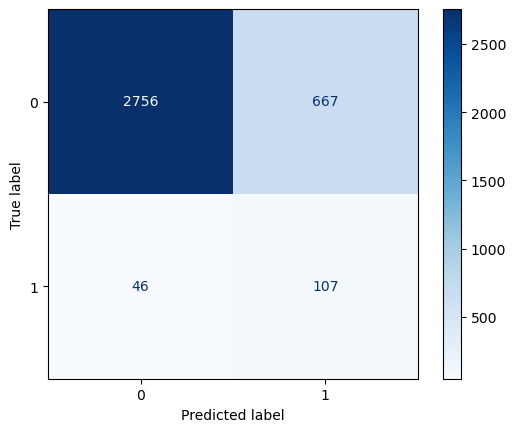

In [12]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_os, preds_binary_os)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[3410   13]
 [ 109   44]]


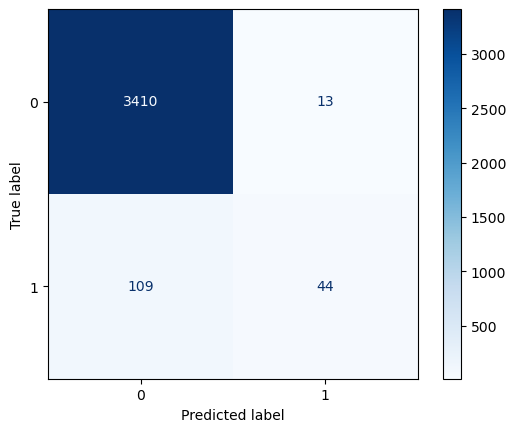

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_os_cat, preds_binary_os_cat)
print('Confusion Matrix:')
print(cm)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [17]:
from xgboost import XGBClassifier, XGBRegressor

xgbc = XGBClassifier(n_estimators=136, max_depth=4, learning_rate=.13, random_state=1)

# fit the model
xgbc.fit(x_test_os, y_test_os)

# Make predictions
train_pred_os = xgbc.predict(x_train_os)
test_pred_os = xgbc.predict(x_test_os)

In [20]:
print('\nRandom Oversampled and categorized Data with Tuned XGB Classifer')
# Print scores
print("--------------------------------------------------------")
print(balanced_accuracy_score(y_train_os, train_pred_os),'training score')
print(balanced_accuracy_score(y_test_os, test_pred_os),'testing score')


Random Oversampled and categorized Data with Tuned XGB Classifer
--------------------------------------------------------
0.5149731439923478 training score
0.5163398692810458 testing score


In [15]:
fraud_df = df[df['fraudulent'] == 1]
real_df = df[df['fraudulent'] == 0]

# Display all data within the columns without truncation
#pd.set_option('display.max_colwidth', None)

fraud_df.head(10)

,telecommuting,has_company_logo,has_questions,fraudulent,department_Accounting,department_Administration,department_Administrative,department_Business Development,department_CSD Relay,department_Clerical,...,department_R&D,department_Retail,department_Sales,department_Squiz,department_Tech,department_Technical,department_Technology,department_tech,department_nan,department_infrequent_sklearn
98,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
173,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
180,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
357,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
493,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
537,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
573,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
